In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u

In [5]:
# Load database
# df = pd.read_csv("data/astro_footprint_database.csv")
df = pd.read_csv("data/database.csv")

## Basic statistics

In [6]:
print(f"Total number of observations: {df.count()['EXPTIME']}")
total_time = df['EXPTIME'].sum()
hours = total_time // 3600
minutes = (total_time % 3600) // 60
seconds = total_time % 60
print(f"Total exposure time: {total_time:.0f}s = {hours:.0f}h {minutes:.0f}m {seconds:.0f}s")

Total number of observations: 5575
Total exposure time: 307825s = 85h 30m 25s


In [7]:
df['TARGET'] = df['TARGET'].str.split(' Panel', expand=True)[0]
df_stats = df.groupby(['TARGET']).agg({'EXPTIME': ['sum', 'count'],'RA': ['mean', 'std'],'DEC': ['mean', 'std']})
df_stats['First'] = df.groupby('TARGET').first()['DATE'].str.split('T', expand=True)[0]
df_stats['Last'] = df.groupby('TARGET').last()['DATE'].str.split('T', expand=True)[0]
df_stats

EXPTIME                RA                  DEC            \
                      sum count        mean       std       mean       std   
TARGET                                                                       
29/Amphitrite      4710.0   157  141.001428  0.002492  19.160669  0.004910   
3I-ATLAS           2580.0    16  257.741852  0.000445 -17.974584  0.000583   
Coma Cluster      15600.0   201  194.992092  0.003111  27.992676  0.003159   
HAT-P-18 b        12960.0    72  256.349532  0.002627  33.010830  0.001807   
HAT-P-20b          7080.0    59  111.916106  0.003925  24.337611  0.003294   
Horsehead Nebula  17780.0   711   85.270806  0.027677  -2.471756  0.010017   
M 1                7200.0   260   83.632718  0.005628  22.013808  0.003753   
M 100              6000.0    70  185.564808  0.001740  15.719816  0.001490   
M 104             10500.0   246  189.998774  0.002196 -11.623271  0.003964   
M 11               1800.0    30  282.779163  0.000439  -6.270417  0.000413   
M 12               4710.0   107  251.816589  0.001971  -1.927651  0.004769   
M 27              17070.0   433  299.900746  0.004368  22.720208  0.003076   
M 3               13485.0   459  205.548879  0.016714  28.375097  0.019616   
M 51              22530.0   276  202.474466  0.004260  47.196874  0.004914   
M 63              16980.0   181  198.953536  0.006125  42.027436  0.002494   
M 8                 510.0    17  270.997793  0.000374 -24.363486  0.000209   
M 81               7740.0    69  148.892783  0.007024  69.066432  0.001888   
M 82               9000.0   105  148.866637  0.009330  69.661785  0.003611   
NGC 3842          27930.0   667  175.991423  0.003807  19.949320  0.003467   
NGC 474            4440.0    82   19.921502  0.003858   3.388467  0.004353   
NGC 5957          31920.0   368  233.835589  0.003838  11.971021  0.012903   
NGC 7023          15000.0    97  315.407863  0.012532  68.164567  0.001907   
NGC 7331          24860.0   716  339.208511  0.049055  34.291719  0.098726   
TIC 272758199.01  12960.0    72  237.316982  0.009771  71.443202  0.003316   
TOI-2154b         12480.0   104   71.001980  0.021346  84.364972  0.003373   

                       First        Last  
                                          
TARGET                                    
29/Amphitrite     2025-03-18  2025-03-18  
3I-ATLAS          2025-07-24  2025-07-24  
Coma Cluster      2025-04-30  2025-05-01  
HAT-P-18 b        2025-05-16  2025-05-16  
HAT-P-20b         2025-03-07  2025-03-08  
Horsehead Nebula  2025-01-11  2025-01-12  
M 1               2025-03-02  2025-03-02  
M 100             2025-05-14  2025-05-14  
M 104             2025-05-01  2025-05-01  
M 11              2025-08-24  2025-08-24  
M 12              2025-08-11  2025-08-11  
M 27              2025-07-09  2025-07-10  
M 3               2024-03-06  2025-04-11  
M 51              2025-04-04  2025-08-22  
M 63              2025-05-14  2025-05-15  
M 8               2025-08-24  2025-08-24  
M 81              2025-04-07  2025-04-07  
M 82              2025-04-11  2025-04-11  
NGC 3842          2025-04-02  2025-04-03  
NGC 474           2024-11-09  2024-11-15  
NGC 5957          2025-04-11  2025-05-14  
NGC 7023          2025-07-21  2025-07-22  
NGC 7331          2024-10-11  2025-07-25  
TIC 272758199.01  2025-03-18  2025-03-19  
TOI-2154b         2025-03-27  2025-03-27

In [8]:
# Update table in README.md
df_md = pd.DataFrame({'Target': df_stats.index.values, 
                      'Total time (s)': df_stats['EXPTIME']['sum'].values, 
                      'Observations': df_stats['EXPTIME']['count'].values, 
                      'RA (deg)': df_stats['RA']['mean'].values, 
                      'DEC (deg)': df_stats['DEC']['mean'].values, 
                      'First': df_stats['First'].values, 
                      'Last': df_stats['Last'].values}, index=None)
str_md = df_md.to_markdown(index=False, floatfmt=".2f", colalign=("left", "right", "right", "right", "right", "left", "left"), tablefmt="github")

with open("README.md", "r") as f:
    text = f.read()
    start = text.find("## Observations statistics")
    # end = text.find("## Observations locations", start + 1)
    end = len(text)

with open("README.md", "w") as f:
    f.write(text[:start])
    f.write("## Observations statistics\n\n")
    f.write(f"* Total number of observations: {df.count()['EXPTIME']}\n")
    f.write(f"* Total exposure time: {total_time:.0f}s = {hours:.0f}h {minutes:.0f}m {seconds:.0f}s\n\n")
    f.write(str_md)
    f.write("\n\n")
    f.write(text[end:])

In [9]:
def frame2icrs(a, b, f_in='galactic'):
    coord = SkyCoord(a, b, unit=u.rad, frame=f_in)
    coord_out = coord.transform_to('icrs')
    return coord_out.ra.wrap_at('180d').radian, coord_out.dec.radian

def frame2gal(a, b, f_in='icrs'):
    coord = SkyCoord(a, b, unit=u.rad, frame=f_in)
    coord_out = coord.transform_to('galactic')
    return coord_out.l.wrap_at('180d').radian, coord_out.b.radian

In [10]:
ra_gal, dec_gal = frame2icrs(np.linspace(0, 2*np.pi, 1000), 0, f_in='galactic')
ra_cel, dec_cel = frame2icrs(np.linspace(0, 2*np.pi, 1000), 0, f_in='icrs')
ra_ecl, dec_ecl = frame2icrs(np.linspace(0, 2*np.pi, 1000), 0, f_in='barycentrictrueecliptic')

l_gal, b_gal = frame2gal(np.linspace(0, 2*np.pi, 1000), 0, f_in='galactic')
l_cel, b_cel = frame2gal(np.linspace(0, 2*np.pi, 1000), 0, f_in='icrs')
l_ecl, b_ecl = frame2gal(np.linspace(0, 2*np.pi, 1000), 0, f_in='barycentrictrueecliptic')

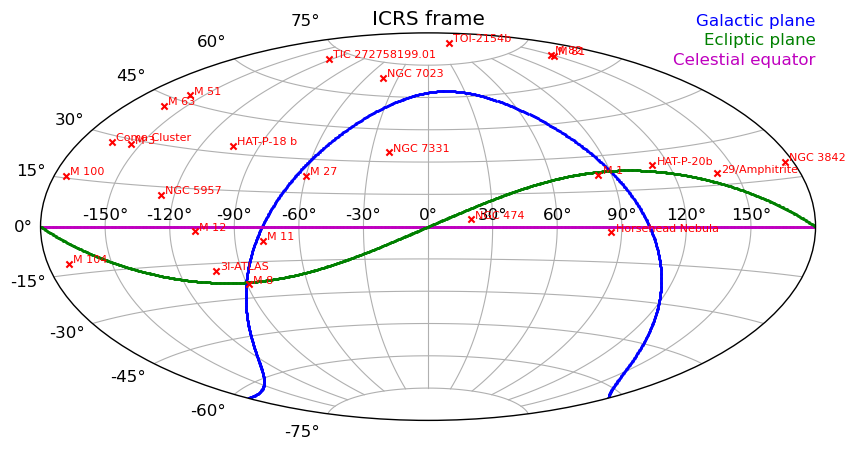

In [11]:
# Plot the footprint of the images
fig, ax = plt.subplots(figsize=(10,6), subplot_kw={'projection': 'aitoff'})
ax.grid(True)
ax.set_axisbelow(True)
ax.scatter(ra_gal, dec_gal, color='b', alpha=1, s=1, label='Galactic plane')
ax.text(1, 1.05, 'Galactic plane', color='b', fontsize=12, ha='right', va='top', transform=ax.transAxes)
ax.scatter(ra_cel, dec_cel, color='m', alpha=1, s=1, label='Celestial equator')
ax.text(1, 0.95, 'Celestial equator', color='m', fontsize=12, ha='right', va='top', transform=ax.transAxes)
ax.scatter(ra_ecl, dec_ecl, color='g', alpha=1, s=1, label='Ecliptic plane')
ax.text(1, 1, 'Ecliptic plane', color='g', fontsize=12, ha='right', va='top', transform=ax.transAxes)

for target in df_stats.index:
    data = df_stats.loc[target]
    ra = data['RA']['mean']
    dec = data['DEC']['mean']
    ra = np.deg2rad(ra)
    dec = np.deg2rad(dec)
    ra = ra-2*np.pi if ra>np.pi else ra
    name = target
    ax.scatter(ra, dec, color='r', marker='x', alpha=1, s=20, label='Footprint')
    ax.annotate(name, xy=(ra, dec), xytext=(3, 3), textcoords='offset points', fontsize=8, ha='left', va='center', color='r')

ax.set_title('ICRS frame')
fig.savefig("images/astro_target-ICRS_database.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

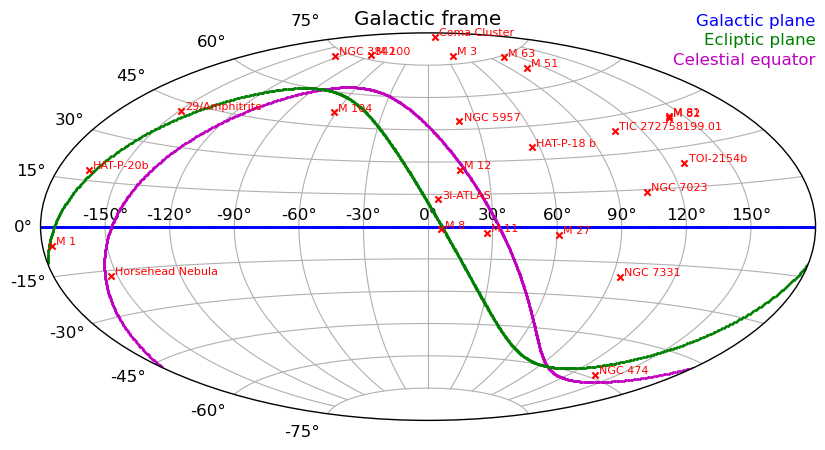

In [12]:
# Plot the footprint of the images
fig, ax = plt.subplots(figsize=(10,6), subplot_kw={'projection': 'aitoff'})
ax.grid(True)
ax.set_axisbelow(True)
ax.scatter(l_gal, b_gal, color='b', alpha=1, s=1, label='Galactic plane')
ax.text(1, 1.05, 'Galactic plane', color='b', fontsize=12, ha='right', va='top', transform=ax.transAxes)
ax.scatter(l_cel, b_cel, color='m', alpha=1, s=1, label='Celestial equator')
ax.text(1, 0.95, 'Celestial equator', color='m', fontsize=12, ha='right', va='top', transform=ax.transAxes)
ax.scatter(l_ecl, b_ecl, color='g', alpha=1, s=1, label='Ecliptic plane')
ax.text(1, 1, 'Ecliptic plane', color='g', fontsize=12, ha='right', va='top', transform=ax.transAxes)

for target in df_stats.index:
    data = df_stats.loc[target]
    ra = data['RA']['mean']
    dec = data['DEC']['mean']
    ra = np.deg2rad(ra)
    dec = np.deg2rad(dec)
    ra = ra-2*np.pi if ra>np.pi else ra
    l, b = frame2gal(ra, dec, f_in='icrs')
    name = target
    ax.scatter(l, b, color='r', marker='x', alpha=1, s=20, label='Footprint')
    ax.annotate(name, xy=(l, b), xytext=(3, 3), textcoords='offset points', fontsize=8, ha='left', va='center', color='r')

ax.set_title('Galactic frame')
fig.savefig("images/astro_target-GAL_database.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Footprint of images

100%|██████████| 3687/3687 [00:09<00:00, 374.20it/s]


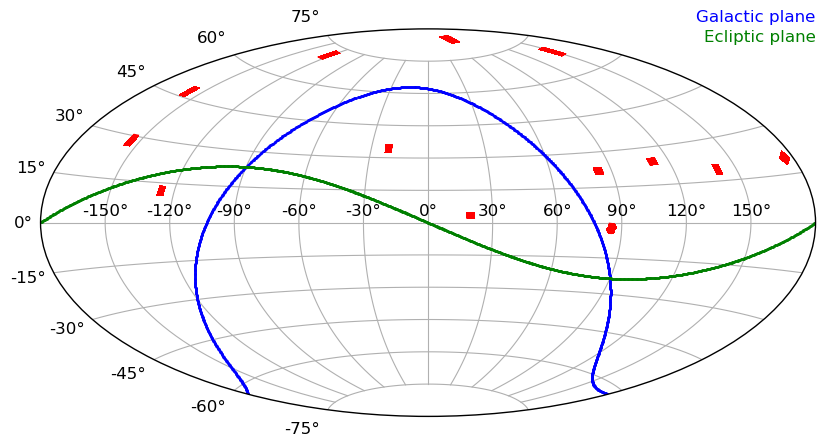

In [ ]:
# Plot the footprint of the images
fig, ax = plt.subplots(figsize=(10,6), subplot_kw={'projection': 'aitoff'})
ax.grid(True)
ax.set_axisbelow(True)
ax.scatter(ra_gal, dec_gal, color='b', alpha=1, s=1, label='Galactic plane')
ax.text(1, 1.05, 'Galactic plane', color='b', fontsize=12, ha='right', va='top', transform=ax.transAxes)
ax.scatter(ra_ecl, dec_ecl, color='g', alpha=1, s=1, label='Ecliptic plane')
ax.text(1, 1, 'Ecliptic plane', color='g', fontsize=12, ha='right', va='top', transform=ax.transAxes)

for obs in tqdm(range(len(df))):
# for obs in range(100):
    # Load footprint
    footprint = np.array([[df['FP1_RA'][obs], df['FP1_DEC'][obs]],
                          [df['FP2_RA'][obs], df['FP2_DEC'][obs]],
                          [df['FP3_RA'][obs], df['FP3_DEC'][obs]],
                          [df['FP4_RA'][obs], df['FP4_DEC'][obs]]])
    # Load WCS
    wcs = WCS()
    wcs.wcs.crval = [df['CRVAL1'][obs], df['CRVAL2'][obs]]
    wcs.wcs.ctype = [df['CTYPE1'][obs], df['CTYPE2'][obs]]
    wcs.wcs.crpix = [df['CRPIX1'][obs], df['CRPIX2'][obs]]
    wcs.wcs.cd = [[df['CD1_1'][obs], df['CD1_2'][obs]],
                  [df['CD2_1'][obs], df['CD2_2'][obs]]]
    # Exapnd the footprint for visualization
    header = fits.Header()
    scale = 5
    header['NAXIS1'] = df['NAXIS1'][obs] * scale
    header['NAXIS2'] = df['NAXIS2'][obs] * scale
    wcs.wcs.crpix[0] = wcs.wcs.crpix[0] * scale
    wcs.wcs.crpix[1] = wcs.wcs.crpix[1] * scale
    footprint = wcs.calc_footprint(header)
    # Plot the footprint of the image
    fp = np.deg2rad(footprint)
    fp[fp>np.pi] -= 2*np.pi
    q = Polygon(fp, closed=True, edgecolor='none', facecolor='r', alpha=1)
    ax.add_patch(q)

ax.set_title('ICRS frame')
fig.savefig("images/astro_footprint_database.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Footprint per target

In [61]:
targets = np.unique(df['TARGET'])

C:\Users\aurel\AppData\Local\Temp\ipykernel_14052\3295554135.py:21: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  q = Polygon(fp, color='r', alpha=0.01, edgecolor='none', closed=True)


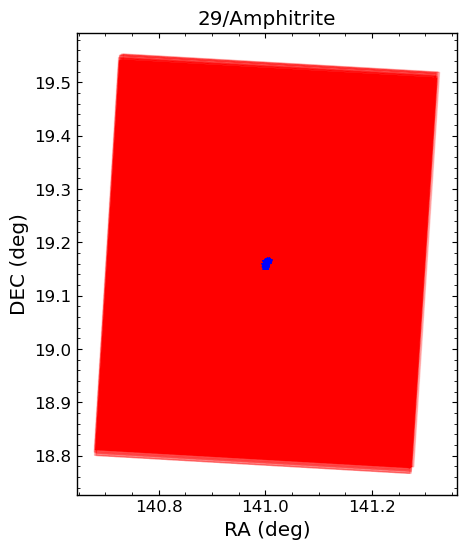

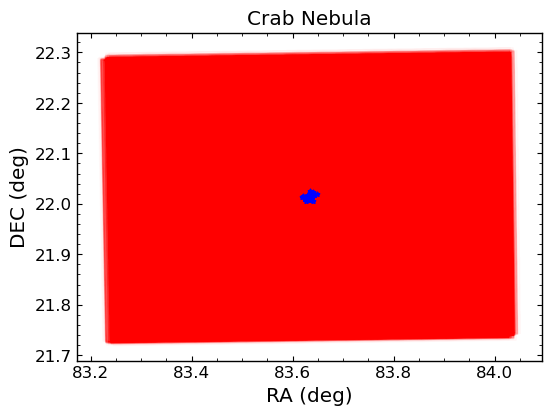

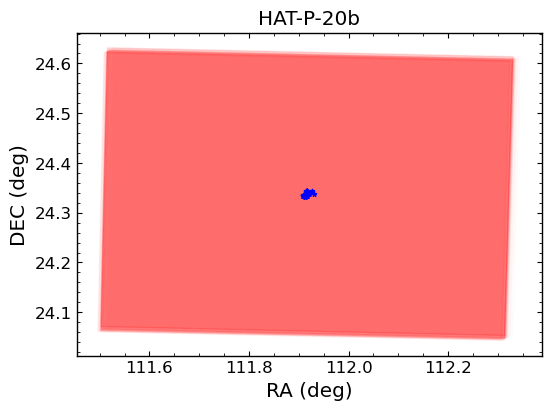

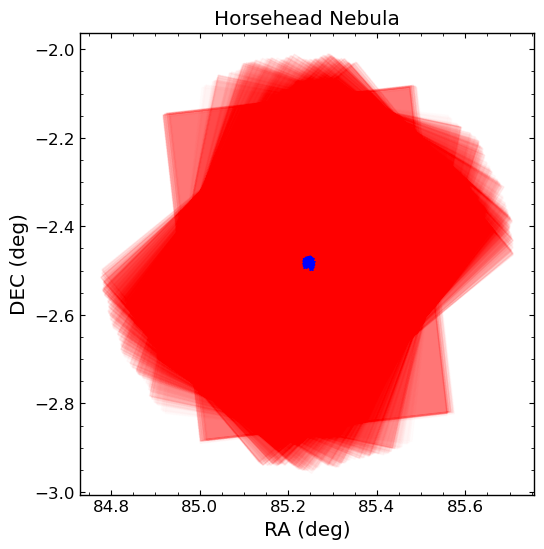

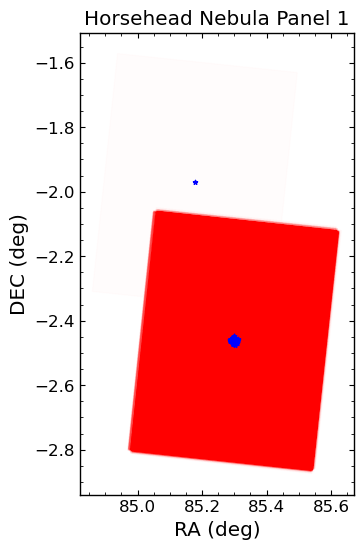

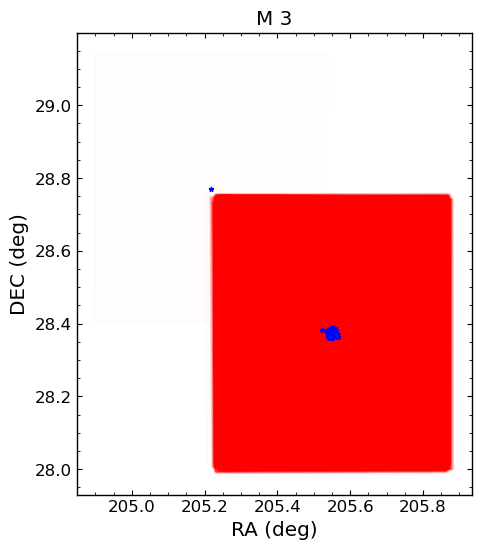

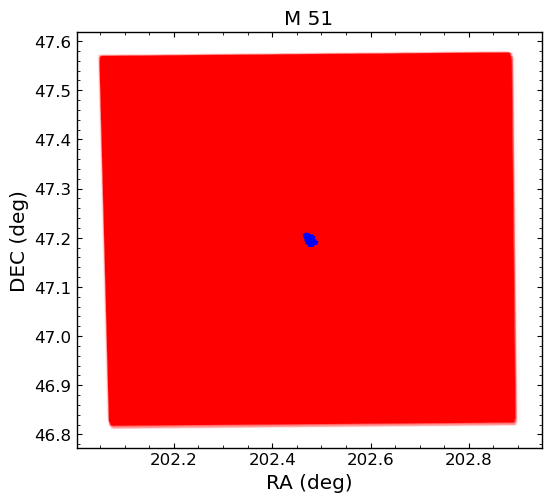

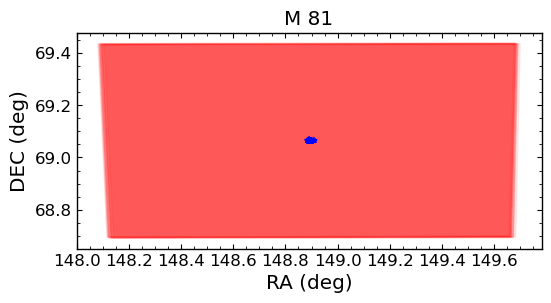

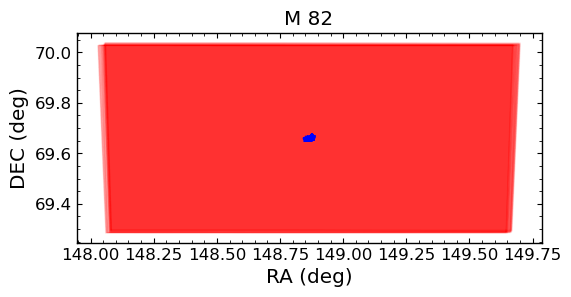

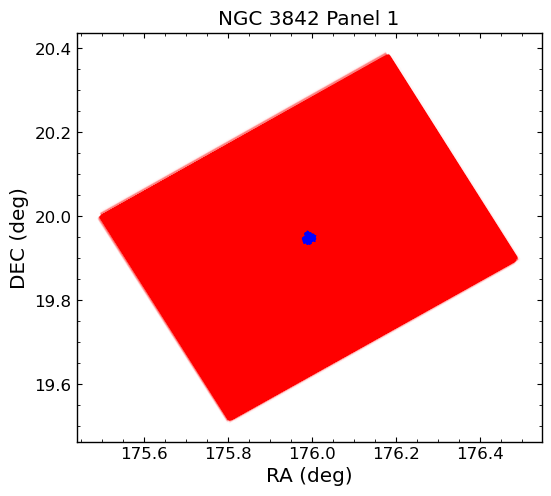

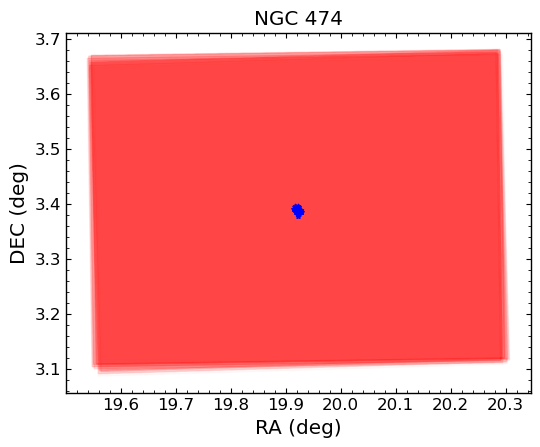

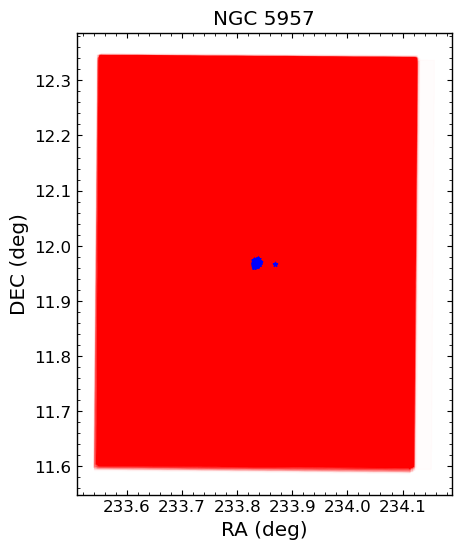

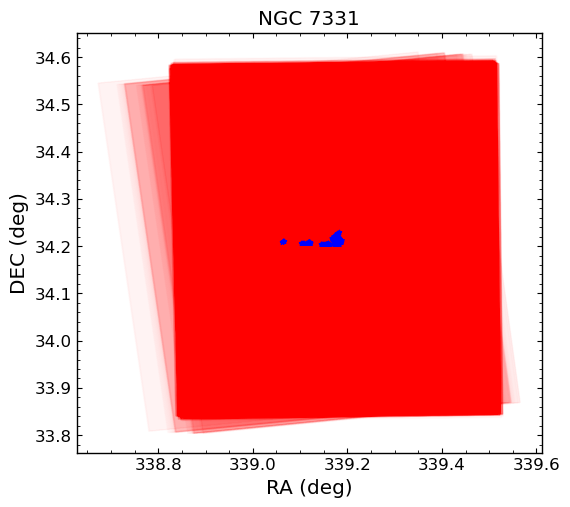

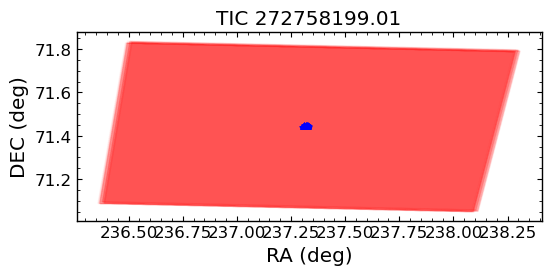

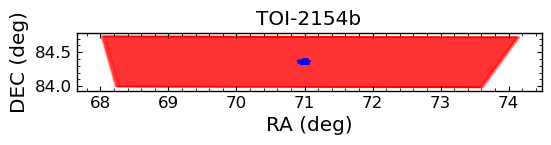

In [62]:
for target in targets:
    ra = df[df['TARGET']==target]['RA']
    dec = df[df['TARGET']==target]['DEC']
    fp1_ra = df[df['TARGET']==target]['FP1_RA']
    fp1_dec = df[df['TARGET']==target]['FP1_DEC']
    fp2_ra = df[df['TARGET']==target]['FP2_RA']
    fp2_dec = df[df['TARGET']==target]['FP2_DEC']
    fp3_ra = df[df['TARGET']==target]['FP3_RA']
    fp3_dec = df[df['TARGET']==target]['FP3_DEC']
    fp4_ra = df[df['TARGET']==target]['FP4_RA']
    fp4_dec = df[df['TARGET']==target]['FP4_DEC']

    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title(target)
    for i in range(len(fp1_ra)):
        # Plot the footprint of the image
        fp = np.array([[fp1_ra.iloc[i], fp1_dec.iloc[i]],
                    [fp2_ra.iloc[i], fp2_dec.iloc[i]],
                    [fp3_ra.iloc[i], fp3_dec.iloc[i]],
                    [fp4_ra.iloc[i], fp4_dec.iloc[i]]])
        q = Polygon(fp, color='r', alpha=0.01, edgecolor='none', closed=True)
        ax.add_patch(q)
    ax.scatter(ra, dec, marker='*', s=10, color='b')
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('DEC (deg)')
    ax.set_aspect('equal')
    plt.show()